# Submission to the ArangoDB Hackathon
## By Patrick Wendo

The dataset used in this notebook is available on [Kaggle](https://www.kaggle.com/datasets/andreuvallhernndez/myanimelist)

In [20]:
!pip3 install kagglehub pandas numpy networkx matplotlib nx_arangodb scipy python-dotenv
!pip3 install --upgrade langchain langchain-community langchain-openai langgraph

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 KB 422.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 KB 1.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: langchain-openai
    Found existing installation: langchain-openai 0.3.5
    Uninstalling langchain-openai-0.3.5:
      Successfully uninstalled langchain-openai-0.3.5
  Attempting uninstall: langgraph
    Found existing installation: langgraph 0.2.72
    Uninstalling langgraph-0.2.72:
      Successfully uninstalled langgraph-0.2.72


In [1]:
from arango import ArangoClient
from dotenv import load_dotenv

import networkx as nx
import nx_arangodb as nxadb
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import ast
import re
import os
import openai

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

load_dotenv()

db = ArangoClient(hosts="http://localhost:8529").db("hackathon", username="root", password=os.getenv("ARANGO_DB_PASS"), verify=True)

print(db)

anime = pd.read_csv(
    "./datasets/myanimelist/anime_subset.csv"
)

anime.head()

[15:13:29 +0300] [INFO]: NetworkX-cuGraph is unavailable: No module named 'cupy'.


<StandardDatabase hackathon>


,anime_id,title,type,score,scored_by,status,episodes,start_date,end_date,source,...,producers,licensors,synopsis,background,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms
0,5114,Fullmetal Alchemist: Brotherhood,tv,9.10,2037075,finished_airing,64,2009-04-05,2010-07-04,manga,...,"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",After a horrific alchemy experiment goes wrong...,NaN,https://cdn.myanimelist.net/images/anime/1208/...,https://myanimelist.net/anime/5114/Fullmetal_A...,https://www.youtube.com/watch?v=--IcmZkvL0Q,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,['Hagane no Renkinjutsushi: Fullmetal Alchemis...
1,11061,Hunter x Hunter (2011),tv,9.04,1671587,finished_airing,148,2011-10-02,2014-09-24,manga,...,"['VAP', 'Nippon Television Network', 'Shueisha']",['VIZ Media'],Hunters devote themselves to accomplishing haz...,NaN,https://cdn.myanimelist.net/images/anime/1337/...,https://myanimelist.net/anime/11061/Hunter_x_H...,https://www.youtube.com/watch?v=D9iTQRB4XRk,Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,['HxH (2011)']
2,38524,Shingeki no Kyojin Season 3 Part 2,tv,9.05,1491491,finished_airing,10,2019-04-29,2019-07-01,manga,...,"['Production I.G', 'Dentsu', 'Mainichi Broadca...",['Funimation'],Seeking to restore humanity's diminishing hope...,Shingeki no Kyojin adapts content from volumes...,https://cdn.myanimelist.net/images/anime/1517/...,https://myanimelist.net/anime/38524/Shingeki_n...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,[]
3,9253,Steins;Gate,tv,9.07,1348232,finished_airing,24,2011-04-06,2011-09-14,visual_novel,...,"['Frontier Works', 'Media Factory', 'Kadokawa ...",['Funimation'],Eccentric scientist Rintarou Okabe has a never...,Steins;Gate is based on 5pb. and Nitroplus' vi...,https://cdn.myanimelist.net/images/anime/1935/...,https://myanimelist.net/anime/9253/Steins_Gate,https://www.youtube.com/watch?v=27OZc-ku6is,Steins;Gate,STEINS;GATE,[]
4,28851,Koe no Katachi,movie,8.94,1540277,finished_airing,1,2016-09-17,2016-09-17,manga,...,"['Shochiku', 'Pony Canyon', 'Kodansha', 'ABC A...","['Eleven Arts', 'NYAV Post']","As a wild youth, elementary school student Sho...",Koe no Katachi won the following awards: Japan...,https://cdn.myanimelist.net/images/anime/1122/...,https://myanimelist.net/anime/28851/Koe_no_Kat...,https://www.youtube.com/watch?v=XBNWo25izJ8,A Silent Voice,聲の形,['The Shape of Voice']


## DATA EXPLORATION

- We have 2 datasets, anime and manga. 
- These are both relational datasets with a single entry having multiple values. We need to figure out how to represent this data as a graph. 

#### Our Strategy.
- We could represent this as an attributed graph with node attributes and edge attributes. An **attributed graph** is one where aside from node labels, or edge labels, a node or an edge will also have additional metadata. For example, in a graph about people, we could have a node with the label "Anna" with attributes `{position: "CEO", start_date: "2019-08-19"}`. 

- The node label would be the name of the anime/manga. We could also have some columns be extracted to nodes of their own. For instance, an anime could fall into multiple genres. We could have each of those as a separate node. Similarly for columns like studios, themes, producers, licensors and demographics.

In [2]:
anime_columns_to_fix = ["genres", "themes", "demographics", "title_synonyms", "studios"]

def rewrite_anime(col):
    anime[col] = anime[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

for col in anime_columns_to_fix:
    rewrite_anime(col)

##### Data Fix #2
- Because the anime, manga, genres, themes, etc etc will use an ID of some kind, we update the anime ID to be prefixed with `a_<id>`
- Further, the ID should not have any disallowed characters, like whitespace, slashes, backslashes, dots at the beginning, colons, asterisks, question marks, exclamation marks, plus signs, percent signs, ampersands or equal signs, so we perform a search and replace for the new fields. 

In [3]:
def sanitize_text(text):
    """Replace spaces with underscores and remove invalid characters."""
    text = re.sub(r'\s+', '_', text)  # Replace spaces with underscores
    text = re.sub(r'[:;]', '', text)  # Remove colons and semicolons
    return text

def update_anime_id(anime_df):
    """Update anime_id by concatenating it with title, then sanitize."""
    anime_df["anime_id"] = anime_df["anime_id"].astype(str) + "_" + anime_df["title"]
    anime_df["anime_id"] = anime_df["anime_id"].apply(sanitize_text)
    
    print(anime_df["anime_id"])  # Debugging output
    return anime_df


anime = update_anime_id(anime)
anime.head(1)


0         5114_Fullmetal_Alchemist_Brotherhood
1                 11061_Hunter_x_Hunter_(2011)
2     38524_Shingeki_no_Kyojin_Season_3_Part_2
3                              9253_SteinsGate
4                         28851_Koe_no_Katachi
5                         32281_Kimi_no_Na_wa.
6       2904_Code_Geass_Hangyaku_no_Lelouch_R2
7    40028_Shingeki_no_Kyojin_The_Final_Season
Name: anime_id, dtype: object


,anime_id,title,type,score,scored_by,status,episodes,start_date,end_date,source,...,producers,licensors,synopsis,background,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms
0,5114_Fullmetal_Alchemist_Brotherhood,Fullmetal Alchemist: Brotherhood,tv,9.1,2037075,finished_airing,64,2009-04-05,2010-07-04,manga,...,"['Aniplex', 'Square Enix', 'Mainichi Broadcast...","['Funimation', 'Aniplex of America']",After a horrific alchemy experiment goes wrong...,NaN,https://cdn.myanimelist.net/images/anime/1208/...,https://myanimelist.net/anime/5114/Fullmetal_A...,https://www.youtube.com/watch?v=--IcmZkvL0Q,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,[Hagane no Renkinjutsushi: Fullmetal Alchemist...


#### Data fix #3

- Arango DB requires a field with the key `_key` to function as the key for a node. 
- Any value that will become a node should have this key. 


In [4]:
def add_key_column(dataframe, id_column):
    dataframe['_key'] = dataframe[id_column]
    return dataframe

anime = add_key_column(anime, "anime_id")

#### Data Fix #4 
- We want specific columns to become individual dataframes. For instance, `"genres"`, `"title_synonyms"`, `"themes"`, `"demographics"` and `"studios"` should be their own dataframes because each value in those dataframe will be their own nodes.



In [5]:
## Identify Key groups in the following columns: "genres", "themes", "demographics", "studios". These could be shared between anime entries.

def fix_keys(df):
    df["_key"] = df["_key"].astype(str).replace("-", "_", regex=True)
    df["_key"] = df["_key"].astype(str).replace(" ", "_", regex=True)
    return df

def build_new_dataframe(dataframe, column):
    new_explode = anime.explode(column)
    new_dataframe = new_explode.groupby(column)
    new_dataframe = new_dataframe.groups.keys()
    new_dataframe = pd.DataFrame(new_dataframe, columns=[column]).reset_index()
    new_dataframe = add_key_column(new_dataframe, column)
    new_dataframe = fix_keys(new_dataframe)
    new_dataframe = new_dataframe[[column, "_key"]]
    new_dataframe["type"] = column
    return new_dataframe


genre_dataframe = build_new_dataframe(anime, "genres")
demographics_dataframe = build_new_dataframe(anime, "demographics")
studios_dataframe = build_new_dataframe(anime, "studios")
themes_dataframe = build_new_dataframe(anime, "themes")
title_synonyms_dataframe = build_new_dataframe(anime, "title_synonyms")
genre_dataframe

,genres,_key,type
0,Action,Action,genres
1,Adventure,Adventure,genres
2,Award Winning,Award_Winning,genres
3,Drama,Drama,genres
4,Fantasy,Fantasy,genres
5,Sci-Fi,Sci_Fi,genres
6,Supernatural,Supernatural,genres
7,Suspense,Suspense,genres


#### Data Fix #5
- removing unused attributes from the anime dataset. 
- Some columns in the dataset will not be used in defining the attributes for the anime dataset. We filter these out. 

In [6]:
# anime node attributes
node_label = "anime_id"
node_attributes = {
    "_key": "_key",
    "id": "anime_id",
    "name": "title",
    "type": "type", 
    "score": "score", 
    "status": "status",
    "start_date": "real_start_date", 
    "studios": "studios",
    "themes": "themes",
    "demographics": "demographics",
    "genres": "genres",
    "end_date": "real_end_date", 
    "source": "source", 
    "episode_duration": "episode_duration", 
    "total_duration": "total_duration",
    "sfw": "sfw", 
    "start_year": "start_year", 
    "start_season": "start_season", 
    "broadcast_day": "broadcast_day",
    "main_picture": "main_picture",
    "url": "url",
    "trailer_url": "trailer_url",
    "title_english": "title_english",
    "title_japanese": "title_japanese",
    "title_synonyms": "title_synonyms" 
}

# (node_attributes.values())
anime = anime[anime.columns.intersection(list(node_attributes.values()))]

#### Data Fix 6
- We drop the NaN columns

In [7]:
anime.dropna(inplace=True)
anime

,anime_id,title,type,score,status,source,episode_duration,total_duration,sfw,start_year,...,themes,demographics,studios,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms,_key
0,5114_Fullmetal_Alchemist_Brotherhood,Fullmetal Alchemist: Brotherhood,tv,9.10,finished_airing,manga,0 days 00:24:20,1 days 01:57:20,True,2009,...,[Military],[Shounen],[Bones],https://cdn.myanimelist.net/images/anime/1208/...,https://myanimelist.net/anime/5114/Fullmetal_A...,https://www.youtube.com/watch?v=--IcmZkvL0Q,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,[Hagane no Renkinjutsushi: Fullmetal Alchemist...,5114_Fullmetal_Alchemist_Brotherhood
1,11061_Hunter_x_Hunter_(2011),Hunter x Hunter (2011),tv,9.04,finished_airing,manga,0 days 00:23:37,2 days 10:15:16,True,2011,...,[],[Shounen],[Madhouse],https://cdn.myanimelist.net/images/anime/1337/...,https://myanimelist.net/anime/11061/Hunter_x_H...,https://www.youtube.com/watch?v=D9iTQRB4XRk,Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,[HxH (2011)],11061_Hunter_x_Hunter_(2011)
2,38524_Shingeki_no_Kyojin_Season_3_Part_2,Shingeki no Kyojin Season 3 Part 2,tv,9.05,finished_airing,manga,0 days 00:23:55,0 days 03:59:10,True,2019,...,"[Gore, Military, Survival]",[Shounen],[Wit Studio],https://cdn.myanimelist.net/images/anime/1517/...,https://myanimelist.net/anime/38524/Shingeki_n...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,[],38524_Shingeki_no_Kyojin_Season_3_Part_2
3,9253_SteinsGate,Steins;Gate,tv,9.07,finished_airing,visual_novel,0 days 00:24:20,0 days 09:44:00,True,2011,...,"[Psychological, Time Travel]",[],[White Fox],https://cdn.myanimelist.net/images/anime/1935/...,https://myanimelist.net/anime/9253/Steins_Gate,https://www.youtube.com/watch?v=27OZc-ku6is,Steins;Gate,STEINS;GATE,[],9253_SteinsGate
7,40028_Shingeki_no_Kyojin_The_Final_Season,Shingeki no Kyojin: The Final Season,tv,8.80,finished_airing,manga,0 days 00:23:55,0 days 06:22:40,True,2021,...,"[Gore, Military, Survival]",[Shounen],[MAPPA],https://cdn.myanimelist.net/images/anime/1000/...,https://myanimelist.net/anime/40028/Shingeki_n...,https://www.youtube.com/watch?v=SlNpRThS9t8,Attack on Titan: Final Season,進撃の巨人 The Final Season,"[Shingeki no Kyojin Season 4, Attack on Titan ...",40028_Shingeki_no_Kyojin_The_Final_Season


#### Data fix #7
- Because ArangoDB and NetworkX needs a set of edges, we define an edgelist dataframe that contains only the source key and destination key. 


In [8]:
## Building the edge list. 

def build_edge_list(dataframe1, dataframe2, merge_field_1, merge_field_2):
    exploded_df = dataframe1.explode(merge_field_1)
    edge_list_df = exploded_df.merge(dataframe2, left_on=merge_field_1, right_on=merge_field_2)
    edge_list_df = edge_list_df[["_key_x", "_key_y", "type_y"]]
    print(edge_list_df.columns)
    return edge_list_df

demographics_edge_list = build_edge_list(anime, demographics_dataframe, "demographics", "_key")
genres_edge_list = build_edge_list(anime, genre_dataframe, "genres", "_key")
themes_edge_list = build_edge_list(anime, themes_dataframe, "themes", "_key")
studios_edge_list = build_edge_list(anime, studios_dataframe, "studios", "_key")
# title_synonyms_dataframe = build_edge_list(anime, title_synonyms_dataframe, "title_synonyms", "_key")

Index(['_key_x', '_key_y', 'type_y'], dtype='object')
Index(['_key_x', '_key_y', 'type_y'], dtype='object')
Index(['_key_x', '_key_y', 'type_y'], dtype='object')
Index(['_key_x', '_key_y', 'type_y'], dtype='object')


### NetworkX

- Let's attempt to add the nodes from the dataframes and the edges from the edgelist

In [9]:
genre_dataframe

,genres,_key,type
0,Action,Action,genres
1,Adventure,Adventure,genres
2,Award Winning,Award_Winning,genres
3,Drama,Drama,genres
4,Fantasy,Fantasy,genres
5,Sci-Fi,Sci_Fi,genres
6,Supernatural,Supernatural,genres
7,Suspense,Suspense,genres


In [24]:
# Adding nodes for "genres", "themes", "demographics", "studios"
G = nx.Graph()

def add_nodes(G, node_df, key):
    for index, row in node_df.iterrows():
        node_id = row[key]  # Get node identifier (_key)
        attributes = row.drop(key).to_dict()  # Convert other columns to a dictionary
        G.add_node(node_id, **attributes)

add_nodes(G, anime, "_key")
add_nodes(G, genre_dataframe, "genres")
add_nodes(G, themes_dataframe, "themes")
add_nodes(G, demographics_dataframe, "demographics")
add_nodes(G, studios_dataframe, "studios")

# # Add edgelists
G.add_edges_from(genres_edge_list[["_key_x", "_key_y"]].itertuples(index=False, name=None))
G.add_edges_from(demographics_edge_list[["_key_x", "_key_y"]].itertuples(index=False, name=None))
G.add_edges_from(studios_edge_list[["_key_x", "_key_y"]].itertuples(index=False, name=None))
G.add_edges_from(themes_edge_list[["_key_x", "_key_y"]].itertuples(index=False, name=None))


# G = nx.from_pandas_edgelist(genres_edge_list, "_key_y", "_key_x")
G.nodes(data=True)
genres_edge_list


,_key_x,_key_y,type_y
0,5114_Fullmetal_Alchemist_Brotherhood,Action,genres
1,5114_Fullmetal_Alchemist_Brotherhood,Adventure,genres
2,5114_Fullmetal_Alchemist_Brotherhood,Drama,genres
3,5114_Fullmetal_Alchemist_Brotherhood,Fantasy,genres
4,11061_Hunter_x_Hunter_(2011),Action,genres
5,11061_Hunter_x_Hunter_(2011),Adventure,genres
6,11061_Hunter_x_Hunter_(2011),Fantasy,genres
7,38524_Shingeki_no_Kyojin_Season_3_Part_2,Action,genres
8,38524_Shingeki_no_Kyojin_Season_3_Part_2,Drama,genres
9,9253_SteinsGate,Drama,genres


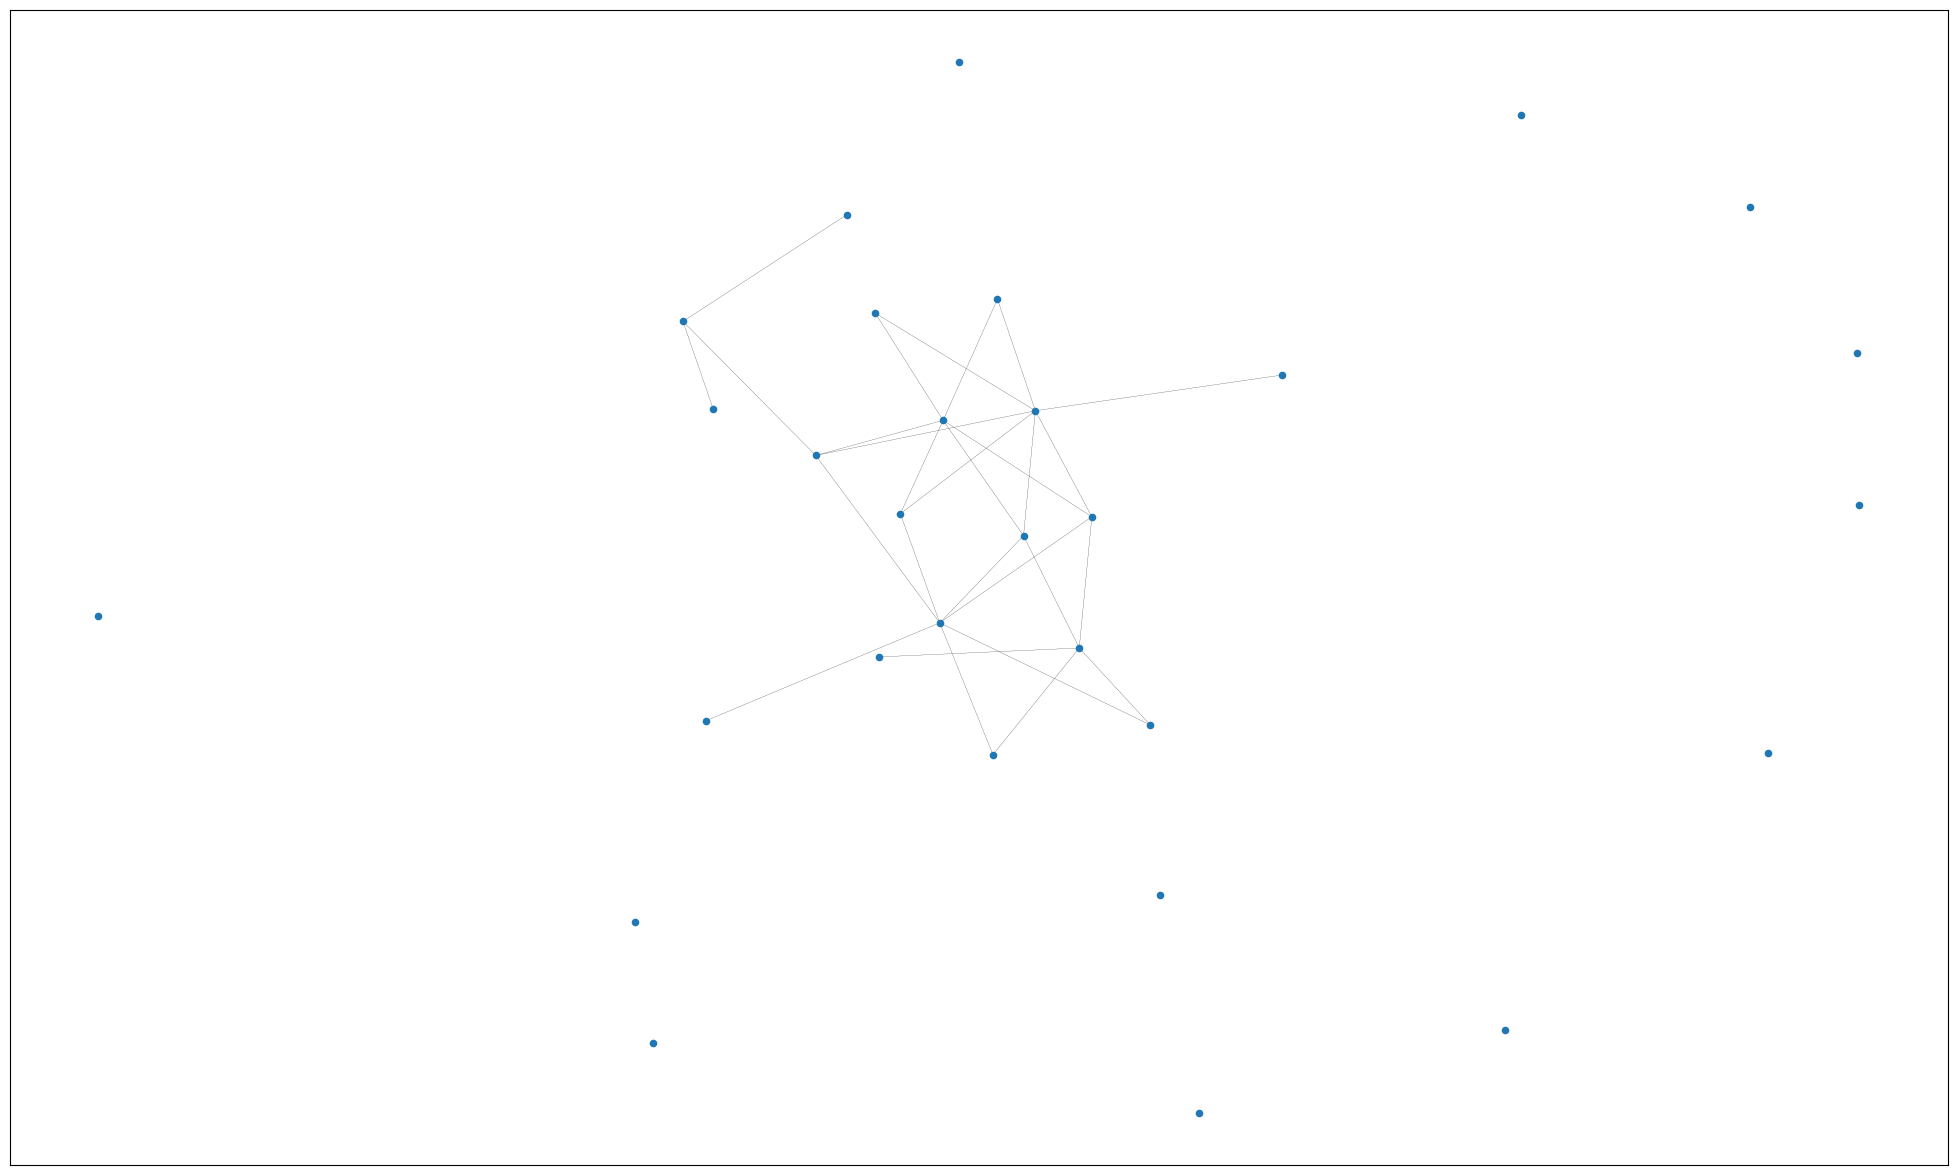

In [11]:
plot_options = {"node_size": 20, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(G, iterations=15, seed=1219)
fig, ax = plt.subplots(figsize=(25, 15))
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

### Load into Arango DB
- Now that we have the graph in networkX, we will load it into ArangoDB

In [12]:
anime

,anime_id,title,type,score,status,source,episode_duration,total_duration,sfw,start_year,...,themes,demographics,studios,main_picture,url,trailer_url,title_english,title_japanese,title_synonyms,_key
0,5114_Fullmetal_Alchemist_Brotherhood,Fullmetal Alchemist: Brotherhood,tv,9.10,finished_airing,manga,0 days 00:24:20,1 days 01:57:20,True,2009,...,[Military],[Shounen],[Bones],https://cdn.myanimelist.net/images/anime/1208/...,https://myanimelist.net/anime/5114/Fullmetal_A...,https://www.youtube.com/watch?v=--IcmZkvL0Q,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,[Hagane no Renkinjutsushi: Fullmetal Alchemist...,5114_Fullmetal_Alchemist_Brotherhood
1,11061_Hunter_x_Hunter_(2011),Hunter x Hunter (2011),tv,9.04,finished_airing,manga,0 days 00:23:37,2 days 10:15:16,True,2011,...,[],[Shounen],[Madhouse],https://cdn.myanimelist.net/images/anime/1337/...,https://myanimelist.net/anime/11061/Hunter_x_H...,https://www.youtube.com/watch?v=D9iTQRB4XRk,Hunter x Hunter,HUNTER×HUNTER（ハンター×ハンター）,[HxH (2011)],11061_Hunter_x_Hunter_(2011)
2,38524_Shingeki_no_Kyojin_Season_3_Part_2,Shingeki no Kyojin Season 3 Part 2,tv,9.05,finished_airing,manga,0 days 00:23:55,0 days 03:59:10,True,2019,...,"[Gore, Military, Survival]",[Shounen],[Wit Studio],https://cdn.myanimelist.net/images/anime/1517/...,https://myanimelist.net/anime/38524/Shingeki_n...,https://www.youtube.com/watch?v=hKHepjfj5Tw,Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,[],38524_Shingeki_no_Kyojin_Season_3_Part_2
3,9253_SteinsGate,Steins;Gate,tv,9.07,finished_airing,visual_novel,0 days 00:24:20,0 days 09:44:00,True,2011,...,"[Psychological, Time Travel]",[],[White Fox],https://cdn.myanimelist.net/images/anime/1935/...,https://myanimelist.net/anime/9253/Steins_Gate,https://www.youtube.com/watch?v=27OZc-ku6is,Steins;Gate,STEINS;GATE,[],9253_SteinsGate
7,40028_Shingeki_no_Kyojin_The_Final_Season,Shingeki no Kyojin: The Final Season,tv,8.80,finished_airing,manga,0 days 00:23:55,0 days 06:22:40,True,2021,...,"[Gore, Military, Survival]",[Shounen],[MAPPA],https://cdn.myanimelist.net/images/anime/1000/...,https://myanimelist.net/anime/40028/Shingeki_n...,https://www.youtube.com/watch?v=SlNpRThS9t8,Attack on Titan: Final Season,進撃の巨人 The Final Season,"[Shingeki no Kyojin Season 4, Attack on Titan ...",40028_Shingeki_no_Kyojin_The_Final_Season


#### Dataframes to Collections
- We will define different node collections for different dataframes. 
- While we can use the networkX arangoDB library to do this, I think it is better if we define our own separate collections and build edges between them manually(for the practice)

In [ ]:
def build_collection(collection_name, dataframe, db):
    if not db.has_collection(collection_name):
        db.create_collection(collection_name)
    else:
        db.delete_collection(collection_name)
        db.create_collection(collection_name)

    collection = db.collection(collection_name)

    nodes = dataframe.to_dict(orient='records')
    collection.insert_many(nodes, overwrite=True)

def build_edge_list(edge_list_name, from_type, to_type, edge_df, db):
    edge_df = edge_df.rename(columns={'_key_x': '_from', '_key_y': '_to'})
    # edge_df.iloc(1)
    if not db.has_collection(edge_list_name):
        db.create_collection(edge_list_name, edge=True)
    else:
        db.delete_collection(edge_list_name)
        db.create_collection(edge_list_name, edge=True)

    edge_collection = db.collection(edge_list_name)

    edges = []
    for _, row in edge_df.iterrows():
        edge = {
            '_from': f'{from_type}/{row["_from"]}',
            '_to': f'{to_type}/{row["_to"]}'
        }
        edges.append(edge)
    edge_collection.insert_many(edges, overwrite=True)

graph_name = "anime_graph"
if db.has_graph(graph_name):
    db.delete_graph(graph_name)


build_collection("studios", studios_dataframe, db)
build_collection("themes", themes_dataframe, db)
build_collection("demographics", demographics_dataframe, db)
build_collection("genres", genre_dataframe, db)
build_collection("anime", anime, db)

build_edge_list("genres_edge_list", "anime", "genres", genres_edge_list, db)
build_edge_list("studios_edge_list", "anime", "studios", studios_edge_list, db)
build_edge_list("themes_edge_list", "anime", "themes", themes_edge_list, db)
build_edge_list("demographics_edge_list", "anime", "demographics", demographics_edge_list, db)
genres_edge_list

edge_definitions = [
    {
        "edge_collection": "genres_edge_list",
        "from_vertex_collections": ["anime"],
        "to_vertex_collections": ["genres"]
    },
    {
        "edge_collection": "studios_edge_list",
        "from_vertex_collections": ["anime"],
        "to_vertex_collections": ["studios"]
    },
    {
        "edge_collection": "themes_edge_list",
        "from_vertex_collections": ["anime"],
        "to_vertex_collections": ["themes"]
    },
    {
        "edge_collection": "demographics_edge_list",
        "from_vertex_collections": ["anime"],
        "to_vertex_collections": ["demographics"]
    },
]

vertex_collections = ["anime", "studios", "demographics", "themes", "genres"]

graph = None
if not db.has_graph(graph_name):
    graph = db.create_graph(graph_name, edge_definitions=edge_definitions)
else:
    db.delete_graph(graph_name)
    graph = db.create_graph(graph_name, edge_definitions=edge_definitions)

anime_graph = ArangoGraph(db)


TypeError: **db** parameter must inherit from arango.database.Database

In [ ]:
# print([len(genre_dataframe), len(anime), len(themes_dataframe), len(demographics_dataframe), len(studios_dataframe)])
print(anime_graph.schema)

[8, 5, 8, 1, 8]


In [13]:
graph_name = "Anime_Subset"
nodes_collection = "anime_nodes"
edges_collection = "anime_edges"

def build_graph():
    graph = db.create_graph(graph_name)
    if not graph.has_vertex_collection(nodes_collection):
        graph.create_vertex_collection(nodes_collection)
    if not graph.has_edge_collection(edges_collection):
        graph.create_edge_definition(
            edge_collection=edges_collection,
            from_vertex_collections=[nodes_collection],
            to_vertex_collections=[nodes_collection]
        )
    else: 
        graph = db.graph(graph_name)

if db.has_graph(graph_name):
    db.delete_graph(graph_name)
    build_graph()
else:
    build_graph()

def sanitize_key(key):
    """Ensure _key is a valid string for ArangoDB (no spaces, special characters except '_', '-')."""
    key = str(key)  # Ensure key is a string
    key = re.sub(r'\s+', '_', key)  # Replace spaces with underscores
    key = re.sub(r'[^a-zA-Z0-9_-]', '-', key)  # Replace invalid characters with hyphens
    return key

def clean_data(data):
    """Sanitize node attributes, ensuring numeric fields are correct and None is handled."""
    clean_data = {}
    for k, v in data.items():
        if isinstance(v, (int, float, bool)):  # Keep numbers as is
            clean_data[k] = v
        elif v is None:  # Replace None with empty string or remove
            clean_data[k] = ""
        else:
            clean_data[k] = str(v)  # Convert everything else to string
    return clean_data

def load_nodes(G, nodes_collection, db):
    nodes = []
    failed_nodes = []  # Store problematic nodes

    for node, data in G.nodes(data=True):
        clean_key = sanitize_key(node)  # Ensure _key is safe
        clean_node_data = clean_data(data)  # Sanitize node attributes

        nodes.append({
            "_key": clean_key,
            **clean_node_data
        })

    if nodes:
        try:
            db.collection(nodes_collection).insert_many(nodes, overwrite=True)
            print(f"✅ Loaded {len(nodes)} nodes into {nodes_collection}")
        except Exception as e:
            print(f"❌ Error inserting nodes: {e}")

            # Identify invalid data causing the error
            for node in nodes:
                try:
                    db.collection(nodes_collection).insert(node, overwrite=True)
                except Exception:
                    failed_nodes.append(node)  # Store the failing node

            print("❌ Failed nodes:", failed_nodes)  # Print bad nodes for debugging

    return nodes, failed_nodes  # Return successful & failed nodes


def load_edges(G, edges_collection, nodes_collection):
    edges=[]
    for u,v, data in G.edges(data=True):
        edges.append({
            "_from": f"{nodes_collection}/{u}",
            "_to": f"{nodes_collection}/{v}",
            **data
        })
    if edges:
        db.collection(edges_collection).insert_many(edges, overwrite=True)
        print(f"✅ Loaded {len(edges)} edges into {edges_collection}")

[node, failed_nodes]= load_nodes(G, nodes_collection, db)
load_edges(G, edges_collection, nodes_collection)
for node in failed_nodes:
    print(node["_key"])

print([len(G.nodes), len(G.edges)])

✅ Loaded 30 nodes into anime_nodes
✅ Loaded 28 edges into anime_edges
[30, 28]


In [14]:
G_adb = nxadb.MultiGraph(
    name=graph_name,
    db=db
)



[15:13:30 +0300] [INFO]: Graph 'Anime_Subset' exists.
[15:13:30 +0300] [INFO]: Default node type set to 'anime_nodes'


In [15]:
print(G_adb)

MultiGraph named 'Anime_Subset' with 30 nodes and 1064 edges


## Building the Agentic App with LangChain & LangGraph

In [16]:
anime_graph = ArangoGraph(db)

In [17]:
@tool
def text_to_aql_to_text(query: str):
    """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and translate the result back into Natural Language.
    """

    llm = ChatOpenAI(
        temperature=0, 
        model_name="Meta-Llama-3.3-70B-Instruct", 
        openai_api_key=sambanova_key,
        base_url="https://api.sambanova.ai/v1"
    )

    chain = ArangoGraphQAChain.from_llm(
    	llm=llm,
    	graph=anime_graph,
    	verbose=True,
        allow_dangerous_requests=True
    )
    
    result = chain.invoke(query)

    return str(result["result"])

# text_to_aql_to_text("Give me an anime based on a manga with themes of Romance that is still airing with a score less than 7.5?")

In [18]:
@tool
def text_to_nx_algorithm_to_text(query):
    """This tool is available to invoke a NetworkX Algorithm on
    the ArangoDB Graph. You are responsible for accepting the
    Natural Language Query, establishing which algorithm needs to
    be executed, executing the algorithm, and translating the results back
    to Natural Language, with respect to the original query.

    If the query (e.g traversals, shortest path, etc.) can be solved using the Arango Query Language, then do not use
    this tool.
    """

    llm = ChatOpenAI(
        temperature=0, 
        model_name="Meta-Llama-3.3-70B-Instruct", 
        openai_api_key=sambanova_key,
        base_url="https://api.sambanova.ai/v1"
    )

    ######################
    print("1) Generating NetworkX code")

    text_to_nx = llm.invoke(f"""
    I have a NetworkX Graph called `G_adb`. It has the following schema: {anime_graph.schema}

    I have the following graph analysis query: {query}.

    Generate the Python Code required to answer the query using the `G_adb` object.

    Be very precise on the NetworkX algorithm you select to answer this query. Think step by step.

    Only assume that networkx is installed, and other base python dependencies.

    Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

    Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    Make sure that `FINAL_RESULT` stores a short & consice answer. Avoid setting this variable to a long sequence.

    Your code:
    """).content

    text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()
    
    print('-'*10)
    print(text_to_nx_cleaned)
    print('-'*10)

    ######################

    print("\n2) Executing NetworkX code")
    global_vars = {"G_adb": G_adb, "nx": nx}
    local_vars = {}
    print(f":: NX CODE :: {[text_to_nx_cleaned, global_vars, local_vars]}")

    try:
        exec(text_to_nx_cleaned, global_vars, local_vars)
        text_to_nx_final = text_to_nx
    except Exception as e:
        print(f"EXEC ERROR: {e}")
        return f"EXEC ERROR: {e}"

        # TODO: Consider experimenting with a code corrector!
        attempt = 1
        MAX_ATTEMPTS = 3

        # while attempt <= MAX_ATTEMPTS
            # ...

    print('-'*10)
    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*10)

    ######################

    print("3) Formulating final answer")

    nx_to_text = llm.invoke(f"""
        I have a NetworkX Graph called `G_adb`. It has the following schema: {anime_graph.schema}

        I have the following graph analysis query: {query}.

        I have executed the following python code to help me answer my query:

        ---
        {text_to_nx_final}
        ---

        The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.
        
        Your response:
    """).content

    return nx_to_text

# text_to_nx_algorithm_to_text("Give me an anime that started before 2012 ")

In [19]:
print(anime_graph.schema)

{'Graph Schema': [{'graph_name': 'Anime_Subset', 'edge_definitions': [{'edge_collection': 'anime_edges', 'from_vertex_collections': ['anime_nodes'], 'to_vertex_collections': ['anime_nodes']}]}], 'Collection Schema': [{'collection_name': 'anime_edges', 'collection_type': 'edge', 'edge_properties': [{'name': '_key', 'type': 'str'}, {'name': '_id', 'type': 'str'}, {'name': '_from', 'type': 'str'}, {'name': '_to', 'type': 'str'}, {'name': '_rev', 'type': 'str'}], 'example_edge': {'_key': '166230', '_id': 'anime_edges/166230', '_from': 'anime_nodes/5114_Fullmetal_Alchemist_Brotherhood', '_to': 'genre_nodes/Action', '_rev': '_jOnmIX----'}}, {'collection_name': 'genre_nodes', 'collection_type': 'document', 'document_properties': [{'name': '_key', 'type': 'str'}, {'name': '_id', 'type': 'str'}, {'name': '_rev', 'type': 'str'}, {'name': 'anime_id', 'type': 'str'}, {'name': 'title', 'type': 'str'}, {'name': 'type', 'type': 'str'}, {'name': 'score', 'type': 'float'}, {'name': 'status', 'type': 's